Load data

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# Read the data from the CSV file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [59]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [61]:
test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [62]:
submission.head()

,id,num_sold
0,230130,100
1,230131,100
2,230132,100
3,230133,100
4,230134,100


# Preprocessing

In [70]:
def preprocess_train(df):
    # to datetime
    df['date'] = pd.to_datetime(df['date'])
    # imputate missing values by mean
    df['num_sold'] = df['num_sold'].fillna(df['num_sold'].mean())
    return df


def preprocess_test(df):
    # to datetime
    df['date'] = pd.to_datetime(df['date'])
    return df

processed_train = preprocess_train(train.copy())
processed_test = preprocess_test(test.copy())

processed_train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,752.527382
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.000000
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.000000
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.000000
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.000000


# EDA

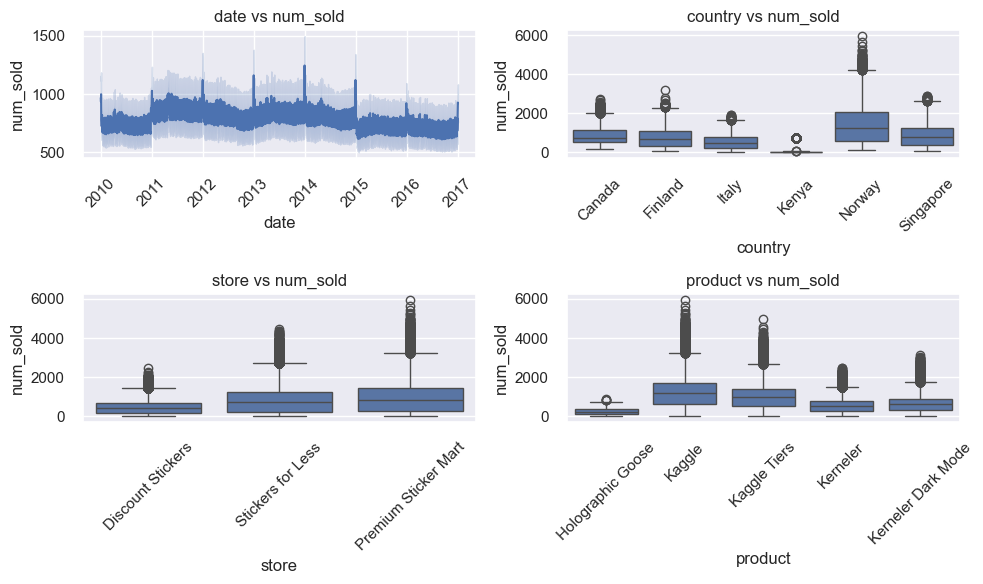

In [72]:
# set theme
sns.set_theme()

# Create subplot
fig, ax = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)

# flatten ax
ax = ax.ravel()

def create_graph(df, x_col, ax, kind):
    # plot lineplot
    if kind == 'line':
      sns.lineplot(x=x_col, y='num_sold', data=df, ax=ax)
    # plot boxplot
    elif kind == 'box':
      sns.boxplot(x=x_col, y='num_sold', data=df, ax=ax)
    # set title
    ax.set_title(f'{x_col} vs num_sold')
    # rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)


create_graph(processed_train, 'date', ax[0], 'line')
create_graph(processed_train, 'country', ax[1], 'box')
create_graph(processed_train, 'store', ax[2], 'box')
create_graph(processed_train, 'product', ax[3], 'box')


# Set pycaret

In [74]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(processed_train,
        target = 'num_sold',
        session_id = 123,
        ignore_features='id',
        date_features=['date'],
        categorical_features=['country', 'store', 'product'],
        encoding_method='dummy')

,Description,Value
0,Session id,123
1,Target,num_sold
2,Target type,Regression
3,Original data shape,"(230130, 6)"
4,Transformed data shape,"(230130, 18)"
5,Transformed train set shape,"(161091, 18)"
6,Transformed test set shape,"(69039, 18)"
7,Ignore features,2
8,Date features,1
9,Categorical features,3


In [75]:
# compare models
best = compare_models(sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,69.8849,12961.6756,113.8385,0.9717,0.4521,0.5963,0.5070
et,Extra Trees Regressor,66.8652,14749.4362,121.4373,0.9679,0.3070,0.3775,6.9140
rf,Random Forest Regressor,68.6809,14837.8545,121.7992,0.9677,0.3156,0.4049,5.5600
dt,Decision Tree Regressor,83.9088,23839.9051,154.3861,0.9480,0.3499,0.4114,0.2420
gbr,Gradient Boosting Regressor,112.7892,26803.2415,163.6835,0.9416,0.7003,1.1465,1.9910
knn,K Neighbors Regressor,118.4812,35736.6008,189.0223,0.9221,0.6741,1.1222,1.8210
lar,Least Angle Regression,261.0189,144596.2957,380.2463,0.6847,1.1715,3.1339,0.1410
br,Bayesian Ridge,261.0190,144596.2962,380.2463,0.6847,1.1715,3.1338,0.2090
ridge,Ridge Regression,261.0190,144596.2954,380.2463,0.6847,1.1715,3.1338,0.1590
lr,Linear Regression,261.0000,144596.0990,380.2460,0.6847,1.1716,3.1348,0.4340


In [76]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,67.5848,15060.5561,122.7215,0.9673,0.3046,0.3574
1,66.4306,14621.5155,120.9195,0.9678,0.3124,0.3608
2,66.4835,14615.8664,120.8961,0.9675,0.3065,0.3995
3,66.8617,15085.3444,122.8224,0.9677,0.3058,0.3862
4,68.0584,15450.7930,124.3012,0.9673,0.3381,0.4681
5,66.3490,14100.9598,118.7475,0.9686,0.3080,0.3808
6,66.5867,14446.0733,120.1918,0.9677,0.2994,0.3615
7,66.8882,15007.4778,122.5050,0.9678,0.3094,0.3226
8,66.6118,14413.2659,120.0553,0.9683,0.2956,0.3681


# Prediction

In [81]:
pred = predict_model(best, data=processed_test)
pred.head()

,id,date,country,store,product,prediction_label
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,724.167678
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle,721.677864
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,617.175903
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler,352.697020
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,419.437590


# Create submission dataframe

In [82]:
submission = pred[['id', 'prediction_label']]
submission.columns = ['id', 'num_sold']
submission.to_csv('submission.csv', index=False)
submission.head()


,id,num_sold
0,230130,724.167678
1,230131,721.677864
2,230132,617.175903
3,230133,352.697020
4,230134,419.437590
